# [DM 2025/26] Phoneme Classification

In [1]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities

## 1. Dataset Analysis

In [2]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data
labels = dataset.target

# Taking feature names and label names
feature_names = dataset.feature_names
label_counts = np.unique_counts(labels)

In [3]:
data.head()

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127


In [4]:
labels.value_counts()

Class
1    3818
2    1586
Name: count, dtype: int64

In [5]:
# Extracting statistics on data
data.describe()

,V1,V2,V3,V4,V5
count,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03
mean,3.330866e-09,5.551443e-09,6.106588e-09,-9.437454e-09,-6.698742e-08
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.933743e+00,-3.038709e+00,-2.795869e+00,-2.485340e+00,-2.367461e+00
25%,-6.697555e-01,-7.790800e-01,-9.505788e-01,-7.583255e-01,-5.405418e-01
50%,-3.801605e-01,-2.150985e-01,-3.861800e-02,-1.422555e-01,-2.127475e-01
75%,3.149040e-01,7.136990e-01,7.771393e-01,6.759035e-01,2.045420e-01
max,3.828575e+00,3.664763e+00,2.630868e+00,3.046948e+00,4.586666e+00


From the statistical report we notice that all the features have mean equal to zero and standard deviation equal to 1, so they are already standard scaled.

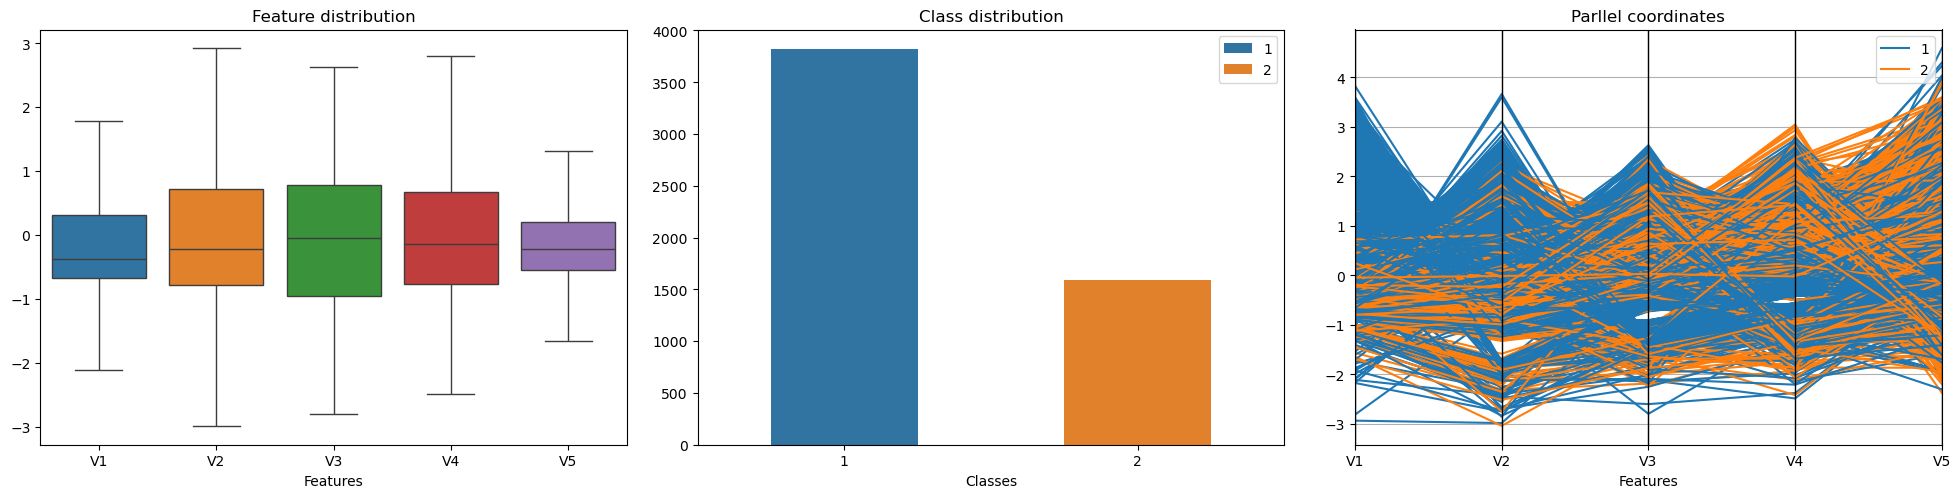

In [6]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Parallel coordinates
parallel_coordinates(
    frame=df,
    class_column="class",
    color=sns.color_palette("tab10"),
    ax=axs[2]
)

# del df # Deleting the temporary dataset from memory

axs[0].set_title("Feature distribution")
axs[0].set_xlabel("Features")

axs[1].set_title("Class distribution")
axs[1].set_xlabel("Classes")

axs[2].set_title("Parllel coordinates")
axs[2].set_xlabel("Features")

plt.show()

The class distribution shows that the two classes are highly imbalanced with class 1 being represented for more than twice class 2, this suggests need for future preprocessing aimed to balance the class frequency.

## 2. Preprocessing

In [7]:
# Preprocessing variables
RANDOM_SEED = 42
TRAIN_SIZE = 0.75

### 2.1 Missing values handling

In [8]:
data.isna().describe()

,V1,V2,V3,V4,V5
count,5404,5404,5404,5404,5404
unique,1,1,1,1,1
top,False,False,False,False,False
freq,5404,5404,5404,5404,5404


### 2.2 Train-Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4053, 5), (1351, 5), (4053,), (1351,))

### 2.3 Balancing

In [10]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
y_train[y_train=="1"].shape, y_train[y_train=="2"].shape

((1196,), (1196,))

In [11]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
y_train[y_train=="1"].shape, y_train[y_train=="2"].shape

((1196,), (1196,))

### 2.3 Reduction

#### 2.3.1 PCA reduction

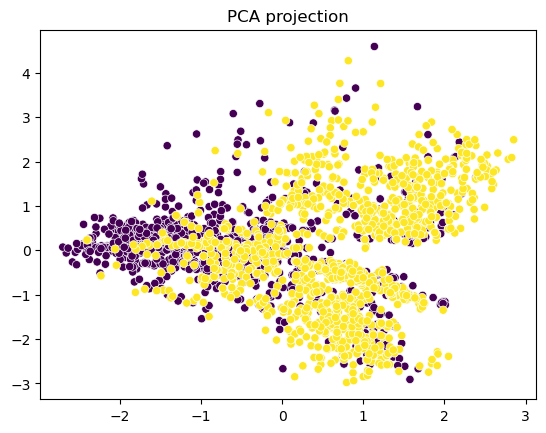

((2392, 2), (1351, 2))

In [12]:
from sklearn.decomposition import PCA

pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

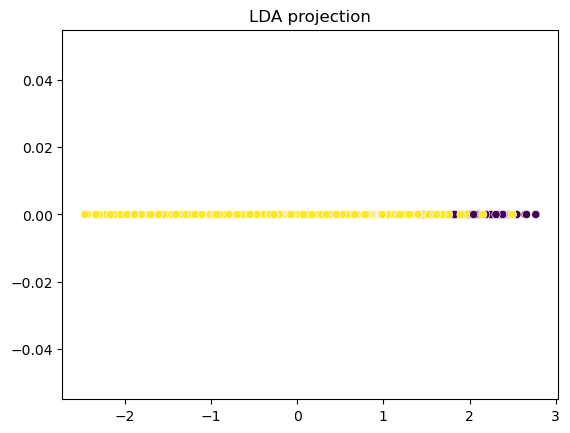

((2392, 1), (1351, 1))

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

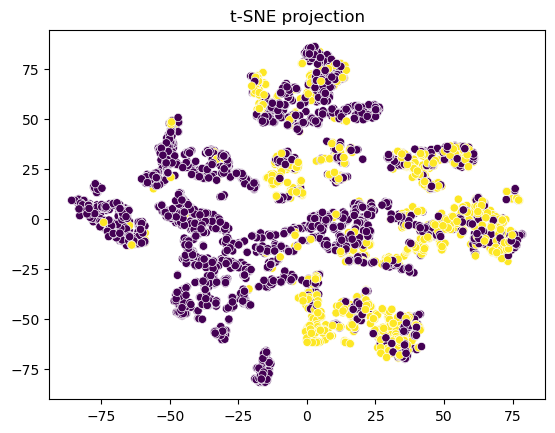

In [14]:
from sklearn.manifold import TSNE

tsne_reductor = TSNE(n_components=2)

# Fitting PCA reductor ONLY with train data to avoid data leakage
data_tsne = tsne_reductor.fit_transform(data)

tsne_plot = sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:,1], c=labels.values.astype(int))
tsne_plot.set_title("t-SNE projection")
plt.show()

## 3. Classification

### 3.1 Shallow Machine Learning

#### 3.1.1 Decision Tree

#### 3.1.2 Naive Bayes

#### 3.1.3 KNN Classifier

### 3.2 Ensemble Classifiers Machine Learning 

#### 3.2.1 Random Forest

#### 3.2.2 AdaBoost

#### 3.2.3 Extreme Gradient Boosting

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

## 4. Evaluation

## 5. Result Discussion